In [2]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import sklearn as sk
import datetime

%load_ext tensorboard

filename = '../_data/filtered_data.csv'
data = pd.read_csv('./_data/filtered_data.csv')

data = data.drop(['Unnamed: 0'],axis=1)

In [2]:
data.head()

,Date,opptAbbr,teamAbbr,Spread,Total,Open_Line_OU,O/U,teamDayOff,teamPTS,teamAST,...,opptFIC40,opptOrtg,opptDrtg,opptEDiff,opptPlay%,opptAR,opptAST/TO,opptSTL/TO,opptPoss,opptPace
0,2017-10-17,CLE,BOS,-3.0,201.0,216.5,0.0,0.0,99.0,24.0,...,55.52,102.7,99.7,3.0,0.42,17.59,1.12,0.18,99.3,99.3
1,2017-10-17,GSW,HOU,1.0,243.0,235.0,1.0,0.0,122.0,28.0,...,86.56,118.6,119.6,-1.0,0.47,27.92,2.00,0.29,102.0,102.0
2,2017-10-18,ORL,MIA,-7.0,225.0,207.0,1.0,0.0,109.0,27.0,...,78.23,110.3,103.6,6.7,0.46,19.43,1.57,0.57,105.2,105.2
3,2017-10-18,WAS,PHI,-5.0,235.0,215.0,1.0,0.0,115.0,25.0,...,80.00,115.1,110.3,4.8,0.47,19.04,2.33,0.89,104.3,104.3
4,2017-10-18,BOS,MIL,8.0,208.0,209.5,0.0,0.0,108.0,19.0,...,58.65,102.2,110.4,-8.2,0.42,19.70,1.92,1.00,97.9,97.9


## NN Model Training
----

Before training the model, we want to do some further preprocessing such as normalizaiton and ensuring the datatype of each column is float type. 

In [3]:
from sklearn.model_selection import train_test_split

def model_preprocessing(dataset,date_range,test_size):
    """
    Takes filtered dataset and returns train_test_split dataset for training model. Removes columns of dtype == "object".
    
    :dataset: input dataset (pd.DataFrame type)
    :seasons: range of seasons eg. ("2016-01-01","2019-01-01")
    :test_size: validation set size
    """
    
    seasonal_data = dataset.loc[np.where((dataset['Date'] > date_range[0]) & (dataset['Date'] < date_range[1]))]
    
    column_ind = [i for i in range(0,len(dataset.dtypes)) if dataset.dtypes[i] == 'object']
    seasonal_data = seasonal_data.drop(columns = seasonal_data.columns[column_ind], axis = 1)
    
    OU_classification = np.asarray(seasonal_data['O/U'])
    
    seasonal_data = seasonal_data.drop(columns = ['O/U'], axis = 1)
    seasonal_data = np.asarray(seasonal_data, dtype = float)   
    seasonal_data = keras.utils.normalize(seasonal_data, axis=1)
     
    return train_test_split(seasonal_data, OU_classification, random_state=42,test_size = test_size)

def prediction_classifier(prediction):
    outcome=[]
    for pred in prediction:
        outcome.append(float(pred.argmax()))
        
    return outcome

X_train, X_test, y_train, y_test = model_preprocessing(dataset = data.drop(columns = ['Total'],axis = 1),
                                                       date_range = ("2015-01-01", "2029-01-01"),
                                                       test_size = 0.2)
    

We will use a two fully connected layer with a flatten layer and a dropout layer in between. 

In [7]:
#tensorboard
log_dir = "./_data/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#earling stopping
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

#model checkpoint
checkpoint_filepath = './_data/checkpoint/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
    

model = tf.keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = X_train[0].shape))
model.add(tf.keras.layers.Dense(128, activation="relu6"))
model.add(keras.layers.Dropout(0.2) )
model.add(tf.keras.layers.Dense(3, activation="softmax"))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.fit(X_train, 
          y_train, 
          epochs=60, 
          validation_split=0.1, 
          batch_size=60,
          callbacks=[callback,tensorboard_callback,model_checkpoint_callback])

Epoch 1/60
62/62 [==============================] - 1s 11ms/step - loss: 0.8467 - accuracy: 0.5125 - val_loss: 0.7401 - val_accuracy: 0.7610
Epoch 2/60
62/62 [==============================] - 0s 8ms/step - loss: 0.7466 - accuracy: 0.5585 - val_loss: 0.7212 - val_accuracy: 0.6951
Epoch 3/60
62/62 [==============================] - 1s 9ms/step - loss: 0.7332 - accuracy: 0.6057 - val_loss: 0.7055 - val_accuracy: 0.7634
Epoch 4/60
62/62 [==============================] - 1s 8ms/step - loss: 0.7187 - accuracy: 0.6523 - val_loss: 0.6865 - val_accuracy: 0.6683
Epoch 5/60
62/62 [==============================] - 1s 8ms/step - loss: 0.6982 - accuracy: 0.6978 - val_loss: 0.6662 - val_accuracy: 0.8220
Epoch 6/60
62/62 [==============================] - 0s 8ms/step - loss: 0.6734 - accuracy: 0.7350 - val_loss: 0.6403 - val_accuracy: 0.8146
Epoch 7/60
62/62 [==============================] - 0s 8ms/step - loss: 0.6445 - accuracy: 0.7705 - val_loss: 0.6076 - val_accuracy: 0.8439
Epoch 8/60
62/62 [=

Below cell runs TensorBoard with information such as epoch_accuracy and epoch_loss graphs

In [12]:
%tensorboard --logdir _data/logs

## Evaluating Model Performance

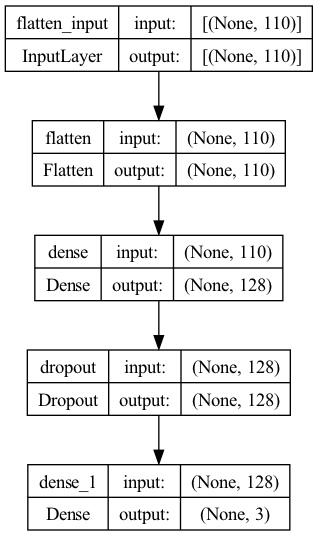

In [13]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,)

In [14]:
prediction_output = model.predict(X_test)
predictions = prediction_classifier(prediction_output)

33/33 [==============================] - 0s 2ms/step


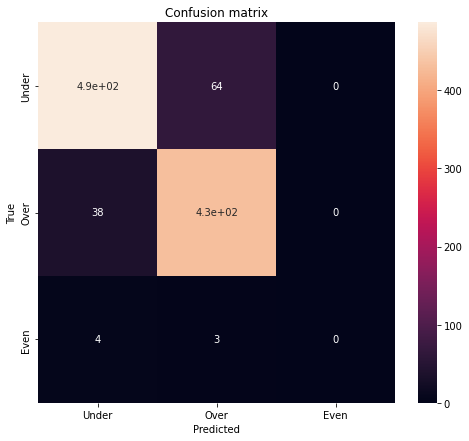

In [16]:
confusion_matrix = sk.metrics.confusion_matrix(y_test,predictions)
outcomes = ['Under','Over','Even']

df_cm = pd.DataFrame(confusion_matrix, index = outcomes, columns = outcomes)
plt.figure(figsize = (8,7))
sn.heatmap(df_cm, annot=True)

plt.title('Confusion matrix')
plt.ylabel('True')
plt.xlabel('Predicted')

plt.show()

We see that even after removing the total score, advanced offensive/defensive boxscore statistics provide strong predictive power in determining whether the resulting game score is over or under the bookkeeper's initial O/U line. We  are successful for up to 93.73% with in game statistics. A more accurate model would be to use the averaged statistics from the previous 5 games to more accurately model real-life betting conditions. 

However, our model tells us that offensive/defensive pace and efficiency are very important predictors for O/U betting.

## NN Model on Trailing Data
----

In [101]:
filename = './_data/trailing_game_data.csv'
trailing_data = pd.read_csv(filename)
trailing_data = trailing_data.dropna().reset_index()
trailing_data = trailing_data.drop(['Unnamed: 0','index'],axis=1)
trailing_data 

,Date,opptAbbr,teamAbbr,Spread,Open_Line_OU,O/U,team2P%,team2PA,team2PM,team3P%,...,opptPlay%,opptPoss,opptSTL,opptSTL%,opptSTL/TO,opptTO,opptTO%,opptTRB,opptTREB%,opptTS%
0,2017-10-17,CLE,BOS,-3.0,216.5,0.0,0.496,50.8,25.2,0.358,...,0.468,98.38,6.6,6.68,0.556,12.6,11.26,41.2,48.94,0.6046
1,2017-10-17,GSW,HOU,1.0,235.0,1.0,0.558,46.0,25.6,0.334,...,0.482,102.48,6.2,6.10,0.406,16.6,14.40,46.2,52.80,0.6528
2,2017-10-18,ORL,MIA,-7.0,207.0,1.0,0.462,63.0,29.2,0.350,...,0.452,102.60,8.4,8.20,0.678,12.4,11.44,43.6,47.16,0.5912
3,2017-10-18,WAS,PHI,-5.0,215.0,1.0,0.548,57.2,31.2,0.330,...,0.458,95.94,8.4,8.62,0.582,14.2,12.54,46.8,56.24,0.5512
4,2017-10-18,BOS,MIL,8.0,209.5,0.0,0.480,54.6,25.8,0.438,...,0.376,98.30,8.0,8.14,0.496,17.6,15.58,39.8,48.58,0.4978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6877,2016-06-08,CLE,GSW,-30.0,206.0,1.0,0.438,45.8,20.2,0.362,...,0.518,93.34,8.0,8.54,0.624,12.6,12.06,48.0,59.90,0.6206
6878,2016-06-10,CLE,GSW,11.0,206.0,0.0,0.424,43.4,18.4,0.390,...,0.532,91.82,8.6,9.26,0.614,13.8,12.96,48.0,60.00,0.6134
6879,2016-06-13,GSW,CLE,15.0,206.0,1.0,0.440,59.4,26.0,0.304,...,0.462,92.86,7.6,8.26,0.610,15.0,14.12,43.4,51.88,0.5828
6880,2016-06-16,CLE,GSW,-14.0,207.0,1.0,0.440,43.8,19.2,0.372,...,0.522,89.98,7.6,8.32,0.668,11.6,10.90,45.8,55.30,0.5798


In [102]:
from sklearn.model_selection import train_test_split

def model_preprocessing(dataset,date_range,test_size):
    """
    Takes filtered dataset and returns train_test_split dataset for training model. Removes columns of dtype == "object".
    
    :dataset: input dataset (pd.DataFrame type)
    :seasons: range of seasons eg. ("2016-01-01","2019-01-01")
    :test_size: validation set size
    """
    
    seasonal_data = dataset.loc[np.where((dataset['game_date'] > date_range[0]) & (dataset['game_date'] < date_range[1]))]
    
    column_ind = [i for i in range(0,len(dataset.dtypes)) if dataset.dtypes[i] == 'object']
    seasonal_data = seasonal_data.drop(columns = seasonal_data.columns[column_ind], axis = 1)
    
    OU_classification = np.asarray(seasonal_data['O/U'])
    
    seasonal_data = seasonal_data.drop(columns = ['O/U'], axis = 1)
    seasonal_data = np.asarray(seasonal_data, dtype = float)   
    seasonal_data = keras.utils.normalize(seasonal_data, axis=1)
     
    return train_test_split(seasonal_data, OU_classification, random_state=42,test_size = test_size)

def prediction_classifier(prediction):
    outcome=[]
    for pred in prediction:
        outcome.append(float(pred.argmax()))
        
    return outcome

In [103]:
X_train, X_test, y_train, y_test = model_preprocessing(dataset = trailing_data,
                                                       date_range = ("2015-01-01", "2020-01-01"),
                                                       test_size = 0.2)

In [104]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=50, max_features="auto", random_state=42)
rf_model.fit(X_train, y_train)

/Users/logange/miniforge3/envs/tensorflow_silicon/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(max_features='auto', n_estimators=50, random_state=42)

In [106]:
predictions = rf_model.score(X_test, y_test)

In [108]:
predictions

0.5975336322869955